In [2]:
import pathlib
import numpy as np
import sys
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import Subset
import torchvision
import torchvision.transforms as transforms

%matplotlib inline

データファイルは次のように配置されている．

```
root_path
 |-numerai_datasets
    |-numerai_training_data.csv
    |-numerai_tournament_data.csv
```

In [3]:
root_path = pathlib.Path('~/Desktop/NUMERAI/')

def make_traintest_data(root_path, folder_name='numerai_datasets):
    numerai_dataset_path = root_path / folder_name
    train_data_path = numerai_dataset_path / 'numerai_training_data.csv'
    test_data_path = numerai_dataset_path / 'numerai_tournament_data.csv'
    train_data = pd.read_csv(train_data_path)
    test_data = pd.read_csv(test_data_path)
    feature_names = [f for f in train_data.columns if "feature" in f]
    return train_data, test_data, feature_names

# ->　以後utils.make_traintest_dataから呼び出す

In [4]:
train_data, test_data, feature_names = make_traintest_data(root_path)

## 1.データの観察

In [5]:
train_data

,id,era,data_type,feature_intelligence1,feature_intelligence2,feature_intelligence3,feature_intelligence4,feature_intelligence5,feature_intelligence6,feature_intelligence7,...,feature_wisdom38,feature_wisdom39,feature_wisdom40,feature_wisdom41,feature_wisdom42,feature_wisdom43,feature_wisdom44,feature_wisdom45,feature_wisdom46,target
0,n000315175b67977,era1,train,0.00,0.50,0.25,0.00,0.50,0.25,0.25,...,1.00,1.00,0.75,0.50,0.75,0.50,1.00,0.50,0.75,0.50
1,n0014af834a96cdd,era1,train,0.00,0.00,0.00,0.25,0.50,0.00,0.00,...,1.00,1.00,0.00,0.00,0.75,0.25,0.00,0.25,1.00,0.25
2,n001c93979ac41d4,era1,train,0.25,0.50,0.25,0.25,1.00,0.75,0.75,...,0.25,0.50,0.00,0.00,0.50,1.00,0.00,0.25,0.75,0.25
3,n0034e4143f22a13,era1,train,1.00,0.00,0.00,0.50,0.50,0.25,0.25,...,1.00,1.00,0.75,0.75,1.00,1.00,0.75,1.00,1.00,0.25
4,n00679d1a636062f,era1,train,0.25,0.25,0.25,0.25,0.00,0.25,0.50,...,0.75,0.75,0.25,0.50,0.75,0.00,0.50,0.25,0.75,0.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501803,nff6a8a8feaeeb52,era120,train,0.50,0.50,0.25,0.00,0.00,0.50,0.75,...,0.50,0.50,0.75,0.50,0.50,0.75,0.25,0.25,0.25,0.50
501804,nff6af62a0996372,era120,train,1.00,0.00,0.00,1.00,0.50,0.75,0.75,...,1.00,1.00,1.00,1.00,1.00,0.00,0.75,1.00,1.00,0.75
501805,nff9288983b8c040,era120,train,0.75,0.50,0.50,0.50,0.25,0.50,0.25,...,1.00,0.75,0.25,1.00,1.00,1.00,0.25,0.00,0.00,0.25
501806,nffaab4e1cacc4b1,era120,train,0.25,0.25,0.25,0.50,0.00,1.00,1.00,...,0.75,0.75,0.75,0.75,0.75,0.50,0.50,0.25,0.75,0.50


In [6]:
test_data

,id,era,data_type,feature_intelligence1,feature_intelligence2,feature_intelligence3,feature_intelligence4,feature_intelligence5,feature_intelligence6,feature_intelligence7,...,feature_wisdom38,feature_wisdom39,feature_wisdom40,feature_wisdom41,feature_wisdom42,feature_wisdom43,feature_wisdom44,feature_wisdom45,feature_wisdom46,target
0,n0003aa52cab36c2,era121,validation,0.25,0.75,0.50,0.50,0.0,0.75,0.50,...,0.75,0.75,1.00,0.75,0.50,0.5,1.00,0.00,0.00,0.25
1,n000920ed083903f,era121,validation,0.75,0.50,0.75,1.00,0.5,0.00,0.00,...,0.50,0.50,0.75,1.00,0.75,0.5,0.50,0.50,0.50,0.50
2,n0038e640522c4a6,era121,validation,1.00,0.00,0.00,1.00,1.0,1.00,1.00,...,0.00,0.00,0.50,0.25,0.00,0.0,0.50,0.50,0.00,1.00
3,n004ac94a87dc54b,era121,validation,0.75,1.00,1.00,0.50,0.0,0.00,0.00,...,0.00,0.00,0.00,0.25,0.00,0.0,0.00,0.25,0.25,0.50
4,n0052fe97ea0c05f,era121,validation,0.25,0.50,0.50,0.25,1.0,0.50,0.50,...,0.50,0.75,0.00,0.00,0.75,1.0,0.00,0.25,1.00,0.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1779475,nffd112483053b7a,eraX,live,0.50,0.25,0.50,1.00,1.0,1.00,1.00,...,0.00,0.00,0.00,0.00,0.75,1.0,0.00,0.00,0.00,NaN
1779476,nffda23fd6297b41,eraX,live,0.75,0.50,0.25,0.75,0.0,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,NaN
1779477,nffed587b72309c4,eraX,live,0.50,0.75,1.00,1.00,0.5,0.25,0.25,...,1.00,1.00,0.75,1.00,1.00,1.0,0.75,1.00,1.00,NaN
1779478,nffeda441259a613,eraX,live,1.00,0.75,0.50,1.00,1.0,1.00,1.00,...,0.50,0.00,0.50,0.50,0.00,0.0,0.00,0.50,0.00,NaN


各特徴量および目的値は0,0,25,0.5,0.75,1のいずれか．各特徴量でスケールは同じなので標準化は必要なさそう．また値は大小関係を持つためカテゴリ変数としてしまうのは適切でないが，値の間隔には意味がなさそうなのでより間隔を圧縮，拡大させることも考えられるかも．

### 1.1era毎のデータ数を描画

In [6]:
def count_samplesize_by_era(df, figsize=(15,5)):
    samplesize_series = df['era'].value_counts() 
    # 'era'列についてユニークな要素それぞれの出現回数を算出．
    # 参考：https://note.nkmk.me/python-pandas-value-counts/
    era_list = []
    samplesize_list = []
    
    # era_list=[1,2,3,...,120], samplesilze_list=[samplesize_series['era1'],...]とする．
    for i in range(1,121):
        era = f'era{i}'
        era_list.append(i)
        samplesize_list.append(samplesize_series[era])
    
    plt.figure(figsize=figsize)
    plt.bar(x=era_list, height=samplesize_list)
    plt.xlabel('era')
    plt.ylabel('sample size')
    plt.show()
    
    return samplesize_list

# -> 以後utils.preprocessから呼び出す

eraごとにサンプルサイズが等しくない．毎eraで違う銘柄(?)の特徴量が示されているっぽい．時系列をどのように扱えば良いのかが不明．

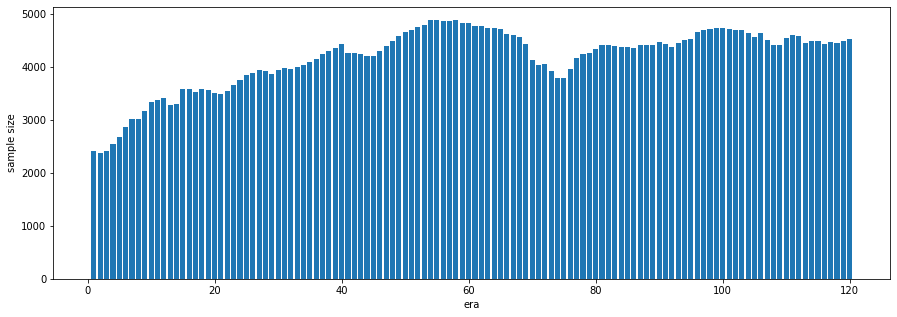

In [7]:
_ = count_samplesize_by_era(train_data)

### 1.2順位相関の計算

今回，データの数値が5種類しかないため値の順位がタイを多く持つことになる．そのような場合に順位相関を計算する時は計算に工夫が必要で，例えば，変数X,Yのデータが次のようであったとする，

| X | Y |
|---|---|
| 1 | 5 |
| 0 | 5 |
| 2 | 4 |
| 1 | 1 |
| 1 | 5 |
| 1 | 3 |

この時，タイ順位に対して出現順に

```
rank_X = [2,6,1,3,4,5]
rank_Y = [1,2,4,6,3,5]
```

と順位を振る方法では，相関係数が変数の並び順に影響を受けてしまう．そこで，タイ順位に対しては平等に順位の平均を割り当てる．例えば，Xの"1"という値は2~5位のため,その平均である3.5が順位として割り当てられる．従って，

```
rank_X = [3.5,6,1,3.5,3.5,3.5]
rank_Y = [2,2,3,6,2,5]
```

と順位をふり，順位相関は次のように計算できる．

```python
rank_x = np.array([3.5, 6, 1, 3.5, 3.5, 3.5])
rank_y = np.array([2, 2, 4, 6, 2, 5])
mean_x = np.mean(rank_x)
mean_y = np.mean(rank_y)
mean_xx = np.mean(rank_x*rank_x)
mean_yy = np.mean(rank_y*rank_y)
mean_xy = np.mean(rank_x*rank_y)
corr = (mean_xy - mean_x*mean_y) / (np.sqrt(mean_xx - mean_x**2)*np.sqrt(mean_yy - mean_y**2))
print(corr)
```

```python
###出力###
-0.35921060405354993
```


- 参考：[Spearman 相関係数を計算するときの注意点](https://qiita.com/PND/items/f368ebaee72df18dd10d)

In [7]:
def mean_rank(sorted_x, argsort_x):
    latest_value = sorted_x[0]
    latest_rank = 1
    same_value_rank_list = [argsort_x[0]] # タイ順位のリスト
    mean_rank_x = -np.ones_like(sorted_x).astype(np.float32)
    for i in range(1,len(sorted_x)):
        x = sorted_x[i]
        if x != latest_value:
            mean = (latest_rank + i) / 2 if i != 1 else 1
            mean_rank_x[same_value_rank_list] = mean
            latest_value = x
            latest_rank = i + 1
            same_value_rank_list = [argsort_x[i]]
        else:
            same_value_rank_list.append(argsort_x[i])
    mean = (latest_rank + len(sorted_x)) / 2
    mean_rank_x[same_value_rank_list] = mean
    
    return mean_rank_x

def calc_spearman_corr(x, y):
    
    #---
    # 配列を降順にソート
    #---
    
    sorted_x = -np.sort(-x)
    # 降順にするために-xをソートする
    sorted_y = -np.sort(-y)
    argsort_x = np.argsort(-x)
    argsort_y = np.argsort(-y)
    
    #---
    # 順位を算出
    #---
    
    rank_x = mean_rank(sorted_x, argsort_x)
    rank_y = mean_rank(sorted_y, argsort_y)
    
    
    #---
    # 順位相関係数を計算
    #---
    
    mean_x = np.mean(rank_x)
    mean_y = np.mean(rank_y)
    mean_xx = np.mean(rank_x*rank_x)
    mean_yy = np.mean(rank_y*rank_y)
    mean_xy = np.mean(rank_x*rank_y)
    corr = (mean_xy - mean_x*mean_y) / \
           (np.sqrt(mean_xx - mean_x**2)*np.sqrt(mean_yy - mean_y**2))
    
    return corr
    
# -> 以後utils.diagnosisから呼び出す

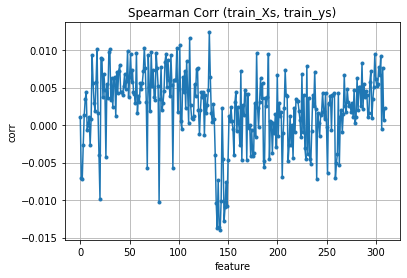

In [9]:
# 各特徴量と目的値との順位相関を計算 (train_data)
target = train_data['target'].values
features = train_data[feature_names].values
corr_arr = np.apply_along_axis(calc_spearman_corr, axis=0, 
                           arr=features, y=target)
fig, ax = plt.subplots()
ax.grid()
ax.plot(corr,
        marker='.', markersize=6)
ax.set_title('Spearman Corr (train_Xs, train_ys)')
ax.set(xlabel='feature', ylabel='corr')
plt.show()

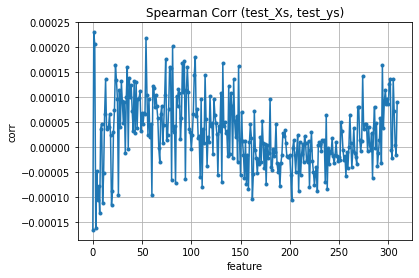

In [10]:
# 各特徴量と目的値との順位相関を計算 (train_data)
target = test_data['target'].values
features = test_data[feature_names].values
corr_arr = np.apply_along_axis(calc_spearman_corr, axis=0, 
                               arr=features, y=target)
fig, ax = plt.subplots()
ax.grid()
ax.plot(corr,
        marker='.', markersize=6)
ax.set_title('Spearman Corr (test_Xs, test_ys)')
ax.set(xlabel='feature', ylabel='corr')
plt.show()

上図からわかる通り目的値と有意な相関を持つ特徴量は存在しないようだが，とりあえず相関が0.005以上の特徴量を選んでデータセットを作り，ベースラインモデルを実装する．

## 2.データセットの作成


In [19]:
def choose_features(df, feature_names, threshold=0.005):
    highcorr_features = []
    target = df['target'].values
    features = df[feature_names].values
    corr_arr = np.apply_along_axis(calc_spearman_corr, axis=0, 
                                   arr=features, y=target)
    highcorr_idx = np.where(corr_arr > threshold)
    highcorr_arr = corr_arr[highcorr_idx]
    return highcorr_idx, highcorr_arr

In [28]:
highcorr_idx, highcorr_arr = choose_features(train_data, feature_names, 0.005)
highcorr_features = [feature_names[int(idx)] for idx in highcorr_idx[0]]
train_Xs = train_data[highcorr_features].values
train_ts = train_data['target'].values
test_Xs = test_data[highcorr_features].values
test_ts = test_data['target'].values
test_corr_arr = np.apply_along_axis(calc_spearman_corr, axis=0, 
                                    arr=test_Xs, y=test_ts)
print('Corr between feature and target (train/test)')
for i in range(len(highcorr_features)):
    feature = highcorr_features[i]
    train_corr = highcorr_arr[i]
    test_corr = test_corr_arr[i]
    print(f'[feature]{feature} [corr]({train_corr:.6f}/{test_corr:.6f})')

Corr between feature and target (train/test)
[feature]feature_charisma1 [corr](0.009310/0.000066)
[feature]feature_charisma2 [corr](0.005661/0.000136)
[feature]feature_charisma5 [corr](0.005696/0.000040)
[feature]feature_charisma6 [corr](0.010077/0.000066)
[feature]feature_charisma10 [corr](0.008991/0.000029)
[feature]feature_charisma11 [corr](0.008782/0.000074)
[feature]feature_charisma13 [corr](0.006794/0.000134)
[feature]feature_charisma16 [corr](0.005490/0.000114)
[feature]feature_charisma18 [corr](0.009736/0.000132)
[feature]feature_charisma19 [corr](0.010115/0.000093)
[feature]feature_charisma21 [corr](0.006236/0.000091)
[feature]feature_charisma23 [corr](0.006226/0.000100)
[feature]feature_charisma24 [corr](0.006398/0.000160)
[feature]feature_charisma26 [corr](0.007098/0.000139)
[feature]feature_charisma28 [corr](0.007219/0.000124)
[feature]feature_charisma29 [corr](0.007980/0.000072)
[feature]feature_charisma33 [corr](0.005262/0.000130)
[feature]feature_charisma34 [corr](0.0067

In [ ]:
class dfDataset(Dataset):
    def __init__(self, Xs, ts):
        self.Xs = Xs
        self.ts = ts
        
    def __len__(self):
        return len(self.Xs)
    
    def __getitem__(self, index):
        x = torch.from_numpy(self.xs[index,:].astype(np.float32))
        t = torch.from_numpy(self.ts[index,:].astype(np.float32))
        return x, t
    
# -> 以後utils.preprocessから呼び出す

In [ ]:
train_dataset = dfDataset(train_Xs, train_ts)
test_dataset = dfDataset(test_Xs, test_ts)
print(f'data size: [tra]{len(train_dataset)} [test]{len(test_dataset)}')

## 3.モデルの作成

In [ ]:
class BaseLineModel(nn.Module):
    def __init__(self, input_dim):
        super(BaseLineModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 4)
        self.fc4 = nn.Linear(4, 1)
        
    def forward(self, x):
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(x))
        out = F.relu(self.fc3(x))
        out = self.fc4(x)
        return out

## 4.訓練

In [ ]:
def train(model, fold_n, train_dataset, test_dataset):
    

In [ ]:
# モデル作ったらmodelsに，trainスクリプトはtrain.py，推論スクリプトはtest.pyに書こうね！